In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.datasets import make_moons

In [3]:

def kernel(X1, X2, scale=1.0, sigma_f=1.0):
    ''' Uncomment for Gaussian Kernel '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp((-0.5 / scale**2) * sqdist)
#    ''' Uncomment for Linear Kernel '''
#    return X1 @ X2.T
def dataSet2():
    X, y = make_moons(n_samples=100, noise=0.1)
    y = np.where(y==0, -1, y)
    y = y.reshape(-1,1)
    S = (y>0).squeeze()
    x_pos = X[S]
    x_neg = X[np.invert(S)]
    return X,y,x_pos,x_neg

In [4]:
def dualOptimizer_hardmargins(H,m,y):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(-np.eye(m))
    h = cvxopt_matrix(np.zeros(m))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

def dualOptimizer_softmargins(H,m,y,C):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye((m)), np.eye(m))))
    h = cvxopt_matrix(np.vstack((np.zeros((m,1)), np.ones((m,1)) * C)))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas


def pred(y,a,X,p,b):
    k = kernel(X,p)
    return (y * a).T @ k +b
    
def predb(y,a,X,p):    
    k = kernel(X,p)
    xc = (y * a).T @ k
    print(k.shape,xc.shape)
    return np.average(y.T-xc)

In [5]:
''' Implementing SVM hard margin '''
'''Converting second term of dual objective function into standard form, a.T*H*a for the optimizer'''
X,y,x_pos,x_neg = dataSet2()
k = kernel(X,X)
t = np.dot(y,y.T)
H = k*t              
m,n = X.shape
C=10000  #Taking C to be 10000 in the constraint. For a higher value of C we get a more stricter margin for the dataset as seen in the observation below 
alphas_hard = dualOptimizer_hardmargins(H,m,y)
alphas_soft = dualOptimizer_softmargins(H,m,y,C)
#Selecting the set of indices S corresponding to non zero parameters
S = (alphas_hard > 1e-4).flatten()
S1= (alphas_soft > 1e-4).flatten()
w = ((y[S] * alphas_hard[S]).T @ X[S]).reshape(-1,1)
w1= ((y[S] * alphas_soft[S]).T @ X[S]).reshape(-1,1)
#Computing b
b = predb(y[S],alphas_hard[S],X[S],X[S])
b1= predb(y[S],alphas_soft[S],X[S],X[S])

#Display results
print('Alphas for hard margins: ',alphas_hard,'\n Support Vectors: ',S.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_hard[alphas_hard > 1e-4])
print('w = ', w.flatten())
print('b = ', b)

(9, 9) (1, 9)
(9, 9) (1, 9)
Alphas for hard margins:  [[3.86108323e-12]
 [3.49914258e-12]
 [5.77122418e-12]
 [4.59262577e-12]
 [6.62916222e-12]
 [7.85564853e-12]
 [6.82372898e-12]
 [4.05504883e-12]
 [9.95838773e-12]
 [1.42276789e-11]
 [1.73634799e-12]
 [3.94557091e-11]
 [8.45661927e-12]
 [4.02503641e-12]
 [2.64313529e-12]
 [3.90944949e-12]
 [2.52548132e-12]
 [4.86647478e-12]
 [1.93581399e-11]
 [4.19813914e-12]
 [1.12665416e-11]
 [8.11682187e-12]
 [8.37042578e-12]
 [4.47303056e-12]
 [8.43618010e+00]
 [1.59941876e-11]
 [5.37321269e-12]
 [7.11066305e+01]
 [1.76276962e+01]
 [8.43324260e-12]
 [8.81814465e-12]
 [3.12664327e-12]
 [4.05387995e-12]
 [1.18255802e-11]
 [2.18529543e-12]
 [3.19008349e-12]
 [3.55849478e-11]
 [3.44162578e-12]
 [2.46922465e-12]
 [3.55177803e-12]
 [2.87182113e-12]
 [1.25336045e-11]
 [2.58124701e-12]
 [3.31145244e-12]
 [3.50765918e+01]
 [7.22473287e-12]
 [2.64357741e-12]
 [3.62462753e-12]
 [2.97940153e-11]
 [3.75835144e-12]
 [9.53970801e-01]
 [1.20780706e-11]
 [2.281655

In [6]:
print('Alphas for soft margins: ',alphas_soft,'\n Support Vectors: ',S1.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_soft[alphas_soft > 1e-4])
print('w = ', w1.flatten())
print('b = ', b1)

Alphas for soft margins:  [[1.83085410e-12]
 [1.58653438e-12]
 [2.34724986e-12]
 [2.15812649e-12]
 [2.87453845e-12]
 [3.48229573e-12]
 [2.74385734e-12]
 [1.47534737e-12]
 [5.06538566e-12]
 [7.41207248e-12]
 [6.84357728e-13]
 [2.75003394e-11]
 [3.18423209e-12]
 [1.68175420e-12]
 [1.21574664e-12]
 [1.73508268e-12]
 [1.08935286e-12]
 [2.29284348e-12]
 [2.91465770e-12]
 [2.00227102e-12]
 [4.22191767e-12]
 [4.29895280e-12]
 [4.04118250e-12]
 [1.69358555e-12]
 [8.43618010e+00]
 [9.81219844e-12]
 [2.26097940e-12]
 [7.11066305e+01]
 [1.76276962e+01]
 [3.92510133e-12]
 [3.72159189e-12]
 [1.41883253e-12]
 [1.75131758e-12]
 [4.79907272e-12]
 [9.86828542e-13]
 [1.22679578e-12]
 [2.12908421e-11]
 [1.37477805e-12]
 [1.07538324e-12]
 [1.40897241e-12]
 [1.18703855e-12]
 [7.77726556e-12]
 [1.06869917e-12]
 [1.39102730e-12]
 [3.50765918e+01]
 [2.80944077e-12]
 [1.20812757e-12]
 [1.77304953e-12]
 [2.13834989e-11]
 [1.61190665e-12]
 [9.53970800e-01]
 [4.70222780e-12]
 [9.55816281e-13]
 [3.91728734e-12]
 [

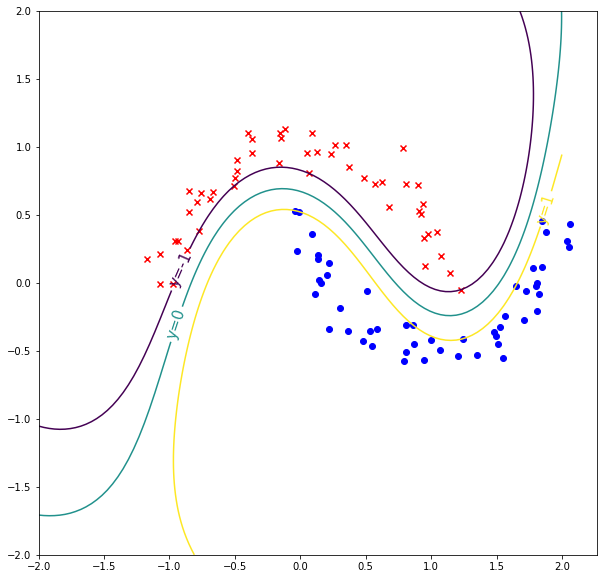

In [9]:
fig = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x0, x1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p = np.array([x0, x1]).reshape(2, -1).T
pr = pred(y[S],alphas_hard[S],X[S],p,b)
#print(pr)
'''hardmargin hyperplanes'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp = plt.contour(x0, x1, pred(y[S],alphas_hard[S],X[S],p,b).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp, fmt='y=%.f', inline=True, fontsize=15)
plt.savefig("hardMarginSVM.png")

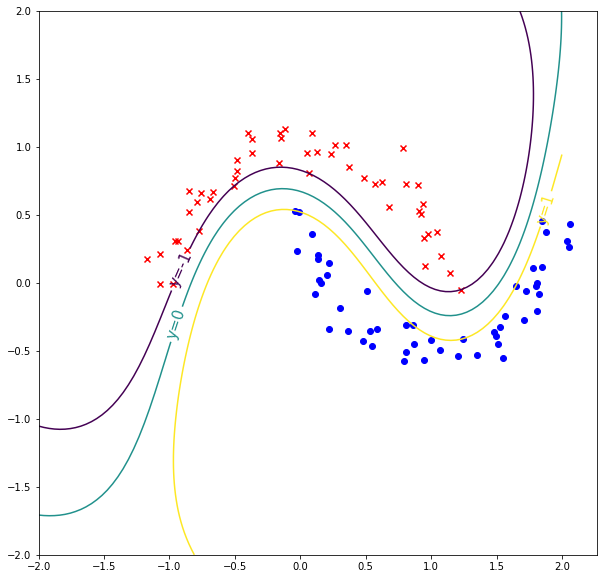

In [10]:
fig1 = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x_0, x_1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p1 = np.array([x_0, x_1]).reshape(2, -1).T
pr1 = pred(y[S],alphas_soft[S],X[S],p1,b1)
#print(pr)
'''softmargin hyperplanes for C=10000'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp1 = plt.contour(x_0, x_1, pred(y[S],alphas_soft[S],X[S],p1,b1).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp1, fmt='y=%.f', inline=True, fontsize=15)
plt.savefig("softMarginSVM.png")